## Step 1: Setup and Data Preprocessing

- Start by importing the necessary libraries and load the spam.csv dataset.

- Preprocess the data by encoding categorical variables, defining features and target, and splitting the data into training and testing sets. Finally, apply PCA to reduce dimensionality.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Load the dataset
spam = pd.read_csv("data/spam.csv")

# Encode categorical variables
categorical_columns = spam.select_dtypes(include = ['object', 'category']).columns.tolist()
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col in categorical_columns:
    spam[col] = label_encoders[col].fit_transform(spam[col])

# Define features and target
X = spam.drop('yesno', axis = 1)
y = spam['yesno']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Reduce dimensionality
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## Step 2: Model Training and Decision Boundary Visualization

- Train a Decision Tree classifier on the PCA-transformed training data.

- Implement and use the `decisionplot` function (from the lecture) to visualize the decision boundary of your trained model.

c:\Users\sunda\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


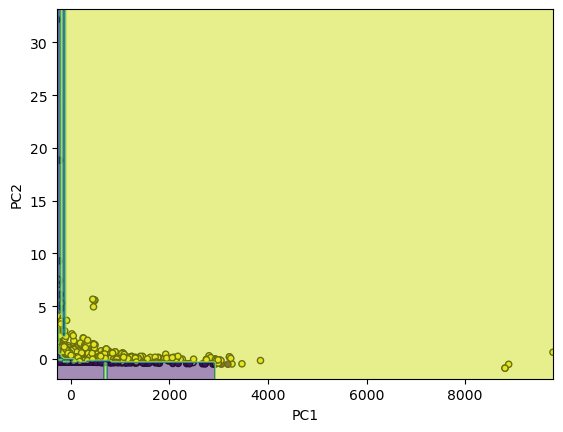

In [26]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Train Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train_pca, y_train)

# Implement the decisionplot function (as provided in the lecture content)
def decisionplot(model, X, y, resolution=216):
    # Split the data into features (X) and the class variable (y)
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    # Predict outcomes for each point on the grid
    if isinstance(model, LinearDiscriminantAnalysis):
        # For LDA, we need to use the decision_function method
        Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    if isinstance(model, LinearDiscriminantAnalysis):
    # Reshape LDA decision function output appropriately
        Z = Z.reshape(-1, 1)
    else:
        Z = Z.reshape(xx.shape)

    # Plot the actual data points
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors='k', s=20)

    # Overlay the decision boundary
    plt.contourf(xx, yy, Z, alpha = 0.5)
    
    # Calculate the accuracy
    predictions = model.predict(X)
    acc = accuracy_score(y, predictions)
    
  
    # Set labels for axes
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])


    plt.show()

# Visualize decision boundary
decisionplot(dtree, pd.DataFrame(X_train_pca, columns = ['PC1', 'PC2']), y_train)


## Step 3: Model Evaluation

- Evaluate your model using accuracy, precision, recall, F1 score, and AUC-ROC metrics.

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predictions
predictions = dtree.predict(X_test_pca)

# Evaluate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average = 'weighted')
recall = recall_score(y_test, predictions, average = 'weighted')
f1 = f1_score(y_test, predictions, average = 'weighted')

# Display results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# For AUC-ROC, binarize the output and calculate AUC-ROC for each class

# Binarize the output for multiclass
y_test_binarized = label_binarize(y_test, classes = np.unique(y_train))
n_classes = y_test_binarized.shape[1]

# Get the probability predictions for each class
y_score = dtree.predict_proba(X_test_pca)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate macro-average ROC-AUC
roc_auc_macro = np.mean(list(roc_auc.values()))
print(f"Macro-average ROC-AUC: {roc_auc_macro:.2f}")

# Calculate micro-average ROC-AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score[:, 1])
roc_auc_micro = auc(fpr["micro"], tpr["micro"])
print(f"Micro-average ROC-AUC: {roc_auc_micro:.2f}")

Accuracy: 0.81
Precision: 0.81
Recall: 0.81
F1 Score: 0.81
Macro-average ROC-AUC: 0.23
Micro-average ROC-AUC: 0.77


## Assignment:
- Implement the missing parts of the code: the decisionplot function and AUC-ROC calculation.

Comment: The missing part of the code has been implemented

- Discuss the results among your peers. Consider the following:

    - Which metric is most informative for this problem and why?

    Comment: Given the nature of our imbalanced dataset, the micro-average is the most informative metric. The micro-average ROC-AUC provides a holistic view, particularly when dealing with imbalanced datasets, while individual metrics such as Accuracy, Precision, Recall, and F1 Score provide insight into specific aspects of the model's performance. In addition, it mitigates the impact of class imbalance on the evaluation by considering the overall discriminative power of all classes.

    - How does the decision boundary visualization help in understanding the model’s performance?

    Comment: By providing a visual representation of the model's behavior, decision boundary visualization complements quantitative metrics. It assists in identifying areas of strength and weakness, determining how well the model generalizes across different regions of feature space, and assessing the impact of dimensionality reduction.

    - Reflect on the impact of PCA on model performance and decision boundary.

    Comment: The PCA process simplifies the feature space and addresses collinearity, which can enhance model performance. In any case, it's necessary to carefully consider its implications, especially in terms of information loss, interpretability, and the suitability of linear assumptions for the specific dataset. After PCA, decision boundaries can be visualized to determine the ability of the model to generalize.

